In [1]:
import base64
from collections import OrderedDict
from typing import List, Dict, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from bokeh.io import output_notebook
from bokeh.models import CategoricalColorMapper, ColumnDataSource, HoverTool
from bokeh.palettes import Category10, Category20, Spectral
from bokeh.plotting import figure, show
from indigo import *
from indigo.ml.clustering import clustering
from indigo.ml.manifold import reduce_dim
from indigo.renderer import IndigoRenderer
from sklearn.cluster import KMeans, SpectralClustering

In [2]:
methods = {
    "SpectralClustering": SpectralClustering,
    "KMeans": KMeans
}

In [3]:
DATASET_PATH = "Adrenergic_dataset.csv"

SMILES = "Structure"
ASSAY_1 = "logP"
ASSAY_2 = "AdrA1A_PCHEMBL_VALUE"

In [4]:
indigo = Indigo()

def indigo_fingerprint_short(structure: str) -> np.ndarray:
    indigo.setOption("ignore-stereochemistry-errors", True)
    indigo.setOption("ignore-bad-valence", True)
    m = indigo.loadMolecule(structure)
    m.aromatize()
    indigo.setOption("similarity-type", "ecfp6")
    indigo.setOption("fp-sim-qwords", 24)
    indigo.setOption("fp-ord-qwords", 6)
    indigo.setOption("fp-any-qwords", 6)
    indigo.setOption("fp-tau-qwords", 3)
    indigo.setOption("fp-ext-enabled", True)
    ecfp = np.frombuffer(m.fingerprint("full").toBuffer(), dtype=np.uint8)
    return ecfp

In [5]:
renderer = IndigoRenderer(indigo)
indigo.setOption("render-output-format", "svg")
indigo.setOption("render-image-size", 350, 170)


def render_image(smiles: str) -> str:
    mol = indigo.loadMolecule(smiles)
    mol.aromatize()
    svg = renderer.renderToString(mol)
    return "data:image/svg+xml;base64," + base64.b64encode(svg.encode()).decode()

In [6]:
output_notebook()

Loading BokehJS ...

### Plot visualisation functions

In [7]:
def resort_clusters(df: pd.DataFrame) -> pd.DataFrame:
    i = 0
    x = df["clusters"][0]
    sorted_colors = [0]
    for cluster in df["clusters"][1:]:
        if cluster != x:
            i += 1
        sorted_colors.append(i)
        x = cluster
    df["sorted_colors"] = sorted_colors
    return df

In [29]:
def clustering_pyplot(
    title: str,
    x: List[float], 
    y: List[float], 
    assay_values: List[List[float]], 
    clusters: List[int], 
    colors: List[str]
):
    df = pd.DataFrame({"x": x, "y": y})
    factors, factor_values = calculate_factor_values(assay_values, clusters)
    df["factor"] = [factor_values[factor] for factor in factors]
    df["clusters"] = clusters
    df.sort_values(by=["factor"], inplace=True, ignore_index=True)
    df = resort_clusters(df)
    
    plt.title(title)
    plt.scatter(df["x"], df["y"], s=10, c=[colors[i] for i in df["sorted_colors"]])
    plt.rcParams['figure.figsize'] = [8, 8]
    plt.show()

In [9]:
def clustering_bokeh_plot(
    title: str,
    x: List[float], 
    y: List[float], 
    ids: List[str], 
    smiles: List[str],
    assay_values: List[float],
    clusters: List[int],
    colors: List[str]
):
    df = pd.DataFrame({'x': x, 'y': y})
    df["id"] = ids
    df["image"] = [render_image(smiles) for smiles in smiles]
    factors, factor_values = calculate_factor_values(assay_values, clusters)
    df["factor"] = [factor_values[factor] for factor in factors]
    df.sort_values(by=["factor"], inplace=True)
    datasource = ColumnDataSource(df)
    
    color_mapping = CategoricalColorMapper(
        factors=sorted(set(factor_values.values())), palette=colors
    )
    
    plot_figure = figure(
        title=title,
        tools="pan, wheel_zoom, reset",
    )
    plot_figure.add_tools(
        HoverTool(
        tooltips="""
            <div>
            <div>
            <img src='@image' style='float: left; margin: 10px 10px 10px 10px'/>
            </div>
            <div>
            <span style='font-size: 12px; color: #224499'>Compound:</span>
            <span style='font-size: 12px'>@id</span>
            </div>
            </div>
            """
        )
    )
    
    plot_figure.circle(
        "x",
        "y",
        color=dict(field="factor", transform=color_mapping),
        legend_field="factor",
        source=datasource,
    )
    return plot_figure

In [10]:
def calculate_factor_values(assay_values: List[List[float]], clusters: List[int]) -> Tuple[List[str], Dict]:
    factors = [str(factor) for factor in clusters]  # noqa

    factor_values = OrderedDict()

    for i, item in enumerate(factors):
        if not item in factor_values:
            factor_values[item] = []
        factor_values[item].append(assay_values[i][0])

    factor_values = {
        key: f"[{round(min(values), 3)}, {round(max(values), 3)}]"
        for key, values in factor_values.items()
    }
    return factors, factor_values

# Experiment for logP values

In [11]:
df = pd.read_csv(DATASET_PATH)

In [12]:
columns = [SMILES, "ID", ASSAY_1]

# CLUSTERING_METHOD = "SpectralClustering"  # basically assigns all the values to one or two clusters
CLUSTERING_METHOD = "KMeans"
N_CLUSTERS = 6  # from 2 to 11

if N_CLUSTERS == 2:
    colors = ["red", "blue"]
else:
    colors = Spectral[N_CLUSTERS]

title = f"Assay value: {ASSAY_1},   Clustering method: {CLUSTERING_METHOD},   Clusters: {N_CLUSTERS}"

In [13]:
dataset = df[[*columns]]
dataset = dataset[dataset[ASSAY_1].notna()]
dataset.head()

,Structure,ID,logP
0,CC\C(=C(\CC)/c1ccc(O)cc1)\c2ccc(O)cc2,CHEMBL411,4.871
1,CSc1ccc2Sc3ccccc3N(CCC4CCCCN4C)c2c1,CHEMBL479,5.900
2,COc1cccc(CCN2C3C4C5CC6C7C5C3C7C2(O)C46)c1,CHEMBL2205811,3.040
3,COc1cc(CN[C@H]2C3C4CC5C6C4CC3C6C25)cc(OC)c1OC,CHEMBL2432051,3.380
4,COc1cccc(CCN2C3C4C5CC6C7C5C3C7C2(O)C46)c1OC,CHEMBL2205813,2.899


In [14]:
assay_1_values = dataset[ASSAY_1].values.reshape(len(dataset[ASSAY_1].values), 1)
clusters_1 = clustering(assay_1_values, method=methods[CLUSTERING_METHOD], n_clusters=N_CLUSTERS, random_state=42)

In [15]:
fingerprints = [indigo_fingerprint_short(s) for s in dataset[SMILES]]
coordinates = reduce_dim(fingerprints, random_state=42, min_dist=1, n_neighbors=15)

In [16]:
x = [c[0] for c in coordinates]
y = [c[1] for c in coordinates]

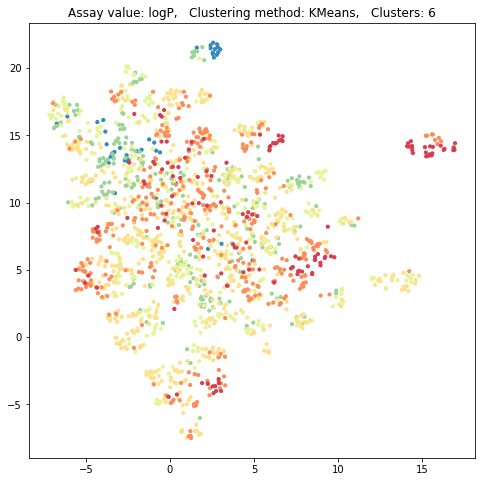

In [31]:
clustering_pyplot(title, x, y, assay_1_values, clusters_1, colors)

In [ ]:
plot1 = clustering_bokeh_plot(title, x, y, dataset["ID"], dataset[SMILES], assay_1_values, clusters_1, colors)
show(plot1)

# Experiment for adrenergic receptor assay (AdrA1A_PCHEMBL_VALUE)

In [19]:
cols = [SMILES, "ID", ASSAY_2]

CLUSTERING_METHOD_2 = "SpectralClustering"
# CLUSTERING_METHOD_2 = "KMeans"
N_CLUSTERS_2 = 4  # from 2 to 11

if N_CLUSTERS == 2:
    colors_2 = ["red", "blue"]
else:
    colors_2 = Spectral[N_CLUSTERS_2]
    
title_2 = f"Assay value: {ASSAY_2}, Clustering method: {CLUSTERING_METHOD_2}, Clusters: {N_CLUSTERS_2}"

In [20]:
ds = df[[*cols]]
ds = ds[ds[ASSAY_2].notna()]
ds.head()

,Structure,ID,AdrA1A_PCHEMBL_VALUE
7,CNC(=O)C(CCN1CCC(O)(CC1)c2ccc(Cl)cc2)(c3ccccc3...,CHEMBL1627,8.00
12,Cc1ccc2c(cccc2n1)N3CCN(CCc4cccc5c4OCc6c(ncn56)...,CHEMBL1241913,8.56
13,COc1ccccc1OCCNCC2CSC(S2)(c3ccccc3)c4ccccc4,CHEMBL1086156,7.45
16,O[C@H]1[C@H](CC[C@@H]1Oc2ccccc2)NC[C@H]3COc4cc...,CHEMBL135974,6.41
19,COc1cccc(OC)c1OCCNC[C@H]2COc3ccccc3O2,CHEMBL1182155,9.39


In [21]:
assay_2_values = ds[ASSAY_2].values.reshape(len(ds[ASSAY_2].values), 1)
clusters_2 = clustering(assay_2_values, method=methods[CLUSTERING_METHOD_2], n_clusters=N_CLUSTERS_2, random_state=42)

In [22]:
fp = [indigo_fingerprint_short(s) for s in ds[SMILES]]
coords = reduce_dim(fp, random_state=42, min_dist=0.5, n_neighbors=15)

x2 = [c[0] for c in coords]
y2 = [c[1] for c in coords]

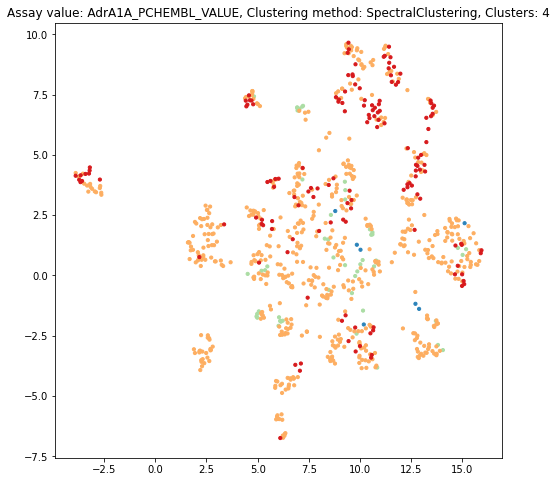

In [32]:
clustering_pyplot(title_2, x2, y2, assay_2_values, clusters_2, colors_2)

In [ ]:
plot2 = clustering_bokeh_plot(title_2, x2, y2, ds["ID"], ds[SMILES], assay_2_values, clusters_2, colors_2)
show(plot2)